In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from math import comb  # Combinations
#from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from itertools import combinations

from utils.ae_torch_classes import *
#from utils.LSTM_gesture_classifier import *

In [39]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [ ]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\"
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'
#metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

full_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df]).reset_index(drop=True)], axis=1)
full_both_df = pd.concat([metadata_cols_df, pd.concat([both_training_users_df, both_test_users_df]).reset_index(drop=True)], axis=1)

In [17]:
print(full_emg_df.shape)
full_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [18]:
emg_data_only_npy = full_emg_df.iloc[:, 3:].values

print(emg_data_only_npy.shape)

(204800, 16)


In [19]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

In [20]:
# Embedding first..

hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))


<All keys matched successfully>

In [23]:
all_emg_embedding = RNNAE_9mir_EMGFull.encode(torch.tensor(emg_data_only_npy, dtype=torch.float32))
X_full_emg_train_embeddings = all_emg_embedding.reshape(all_emg_embedding.shape[0], -1).detach().numpy()

#train_embedding = RNNAE_64_22mir_BothFull.encode(X_3DTensor_full_both)
#test_embedding = RNNAE_64_22mir_BothFull.encode(Xtest_3DTensor_full_both)
#X_full_both_train_embeddings = train_embedding.reshape(train_embedding.shape[0], -1).detach().numpy()
#X_full_both_test_embeddings = test_embedding.reshape(test_embedding.shape[0], -1).detach().numpy()

print(f"X_full_emg_train_embeddings shape: {X_full_emg_train_embeddings.shape}")
#print(f"X_full_both_train_embeddings shape: {X_full_both_train_embeddings.shape}")
#print()
#print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
#print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")

X_full_emg_train_embeddings shape: (204800, 9)


In [24]:
X_emg_df = pd.DataFrame(X_full_emg_train_embeddings)

print(X_emg_df.shape)
X_emg_df.head()

(204800, 9)


,0,1,2,3,4,5,6,7,8
0,0.819932,-0.195209,0.203993,-0.662652,-0.232710,-0.234532,-0.755304,0.312021,0.358541
1,0.186615,-0.630549,0.403146,-0.625808,-0.373283,0.037659,-0.597726,-0.038134,0.337289
2,0.621090,-0.235736,0.686262,-0.814283,-0.408508,0.180361,-0.816356,-0.406810,0.691100
3,0.669751,-0.404265,0.714247,-0.679241,-0.377924,0.098625,-0.793641,-0.485138,0.673027
4,0.574261,-0.820558,0.278629,-0.868722,-0.799502,0.629095,-0.596288,-0.840630,0.061046


In [25]:
X_meta_emg_df = pd.concat([metadata_cols_df, X_emg_df], axis=1)

print(X_meta_emg_df.shape)
X_meta_emg_df.head()

(204800, 12)


,Participant,Gesture_ID,Gesture_Num,0,1,2,3,4,5,6,7,8
0,P102,pan,1,0.819932,-0.195209,0.203993,-0.662652,-0.232710,-0.234532,-0.755304,0.312021,0.358541
1,P102,pan,1,0.186615,-0.630549,0.403146,-0.625808,-0.373283,0.037659,-0.597726,-0.038134,0.337289
2,P102,pan,1,0.621090,-0.235736,0.686262,-0.814283,-0.408508,0.180361,-0.816356,-0.406810,0.691100
3,P102,pan,1,0.669751,-0.404265,0.714247,-0.679241,-0.377924,0.098625,-0.793641,-0.485138,0.673027
4,P102,pan,1,0.574261,-0.820558,0.278629,-0.868722,-0.799502,0.629095,-0.596288,-0.840630,0.061046


In [33]:
num_users = len(X_meta_emg_df['Participant'].unique())
participant_labels = X_meta_emg_df['Participant'].unique()

X_meta_emg_df['Participant'].unique()

array(['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P110', 'P111', 'P112', 'P114', 'P115', 'P116', 'P118', 'P119',
       'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128',
       'P131', 'P132', 'P004', 'P005', 'P006', 'P008', 'P010', 'P011'],
      dtype=object)

In [27]:
X_meta_emg_df.columns

Index(['Participant', 'Gesture_ID', 'Gesture_Num', 0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='object')

In [28]:
df = X_meta_emg_df

# Group by 'Participant' to get user-wide datasets (eg, all gestures, all trials)
grouped = df.groupby(['Participant'])
# Extract the submatrices for each gesture
users_submatrices = [group[1].iloc[:, 3:].values for group in grouped]  # Extract EMG columns only


In [29]:
# Step 3: Calculate the pairwise distances between the submatrices
# Define a custom distance function that operates on submatrices
def submatrix_distance(mat1, mat2, metric='euclidean',  norm='fro', method='mean'):
    # metric: cityblock, chebyshev, cosine
    # norm: mean, fro, np.inf
    if method=='both':
        if norm=='fro' or norm==np.inf:
            return np.linalg.norm(cdist(mat1, mat2, metric=metric), norm)
        else:
            raise ValueError(f"norm {norm} not recognized")
    elif method=='norm':
        return np.linalg.norm(mat1 - mat2, norm)
    elif method=='mean':
        return np.mean(cdist(mat1, mat2, metric=metric))
    else:
        raise ValueError(f"method {method} not recognized")

In [34]:
start_time = time.time()
# Create a distance matrix
num_users = len(users_submatrices)
distance_matrix = np.zeros((num_users, num_users))
for i in range(num_users):
    for j in range(i, num_users):
        dist = submatrix_distance(users_submatrices[i], users_submatrices[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist
print(f"Distance matrix completed in {time.time() - start_time}s")

Distance matrix completed in 615.8205177783966s


In [36]:
def clustermap_users(users_submatrices, participant_labels, dist_metric='euclidean', dist_norm='fro', dist_method='mean', clsmap_title='Pairwise Gesture Distances Clustermap'):
    start_time = time.time()
    num_users = len(users_submatrices)
    distance_matrix = np.zeros((num_users, num_users))
    for i in range(num_users):
        for j in range(i, num_users):
            dist = submatrix_distance(users_submatrices[i], users_submatrices[j], metric=dist_metric,  norm=dist_norm, method=dist_method)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    print(f"Distance matrix completed in {time.time() - start_time}s")
    
    start_time = time.time()
    clsmap_obj = sns.clustermap(distance_matrix, xticklabels=participant_labels, yticklabels=participant_labels, cmap='viridis')
    plt.title(clsmap_title)
    plt.show()
    print(f"Clustermap completed in {time.time() - start_time}s")
    
    return clsmap_obj, distance_matrix

Distance matrix completed in 650.8419997692108s


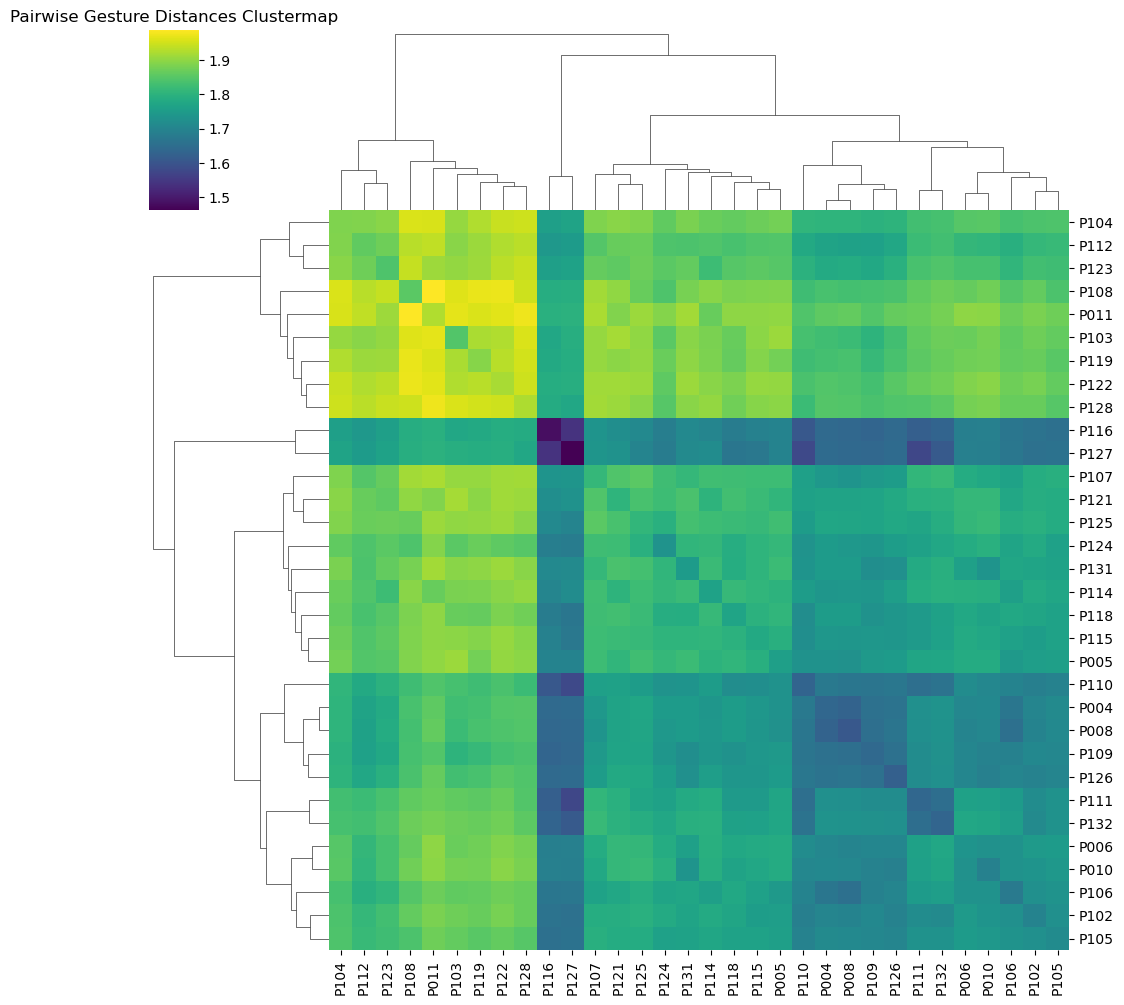

Clustermap completed in 1.9313242435455322s


In [37]:
clsmap_obj1, distance_matrix1 = clustermap_users(users_submatrices, participant_labels, dist_metric='euclidean', dist_norm='fro', dist_method='mean')


Distance matrix completed in 374.64341831207275s


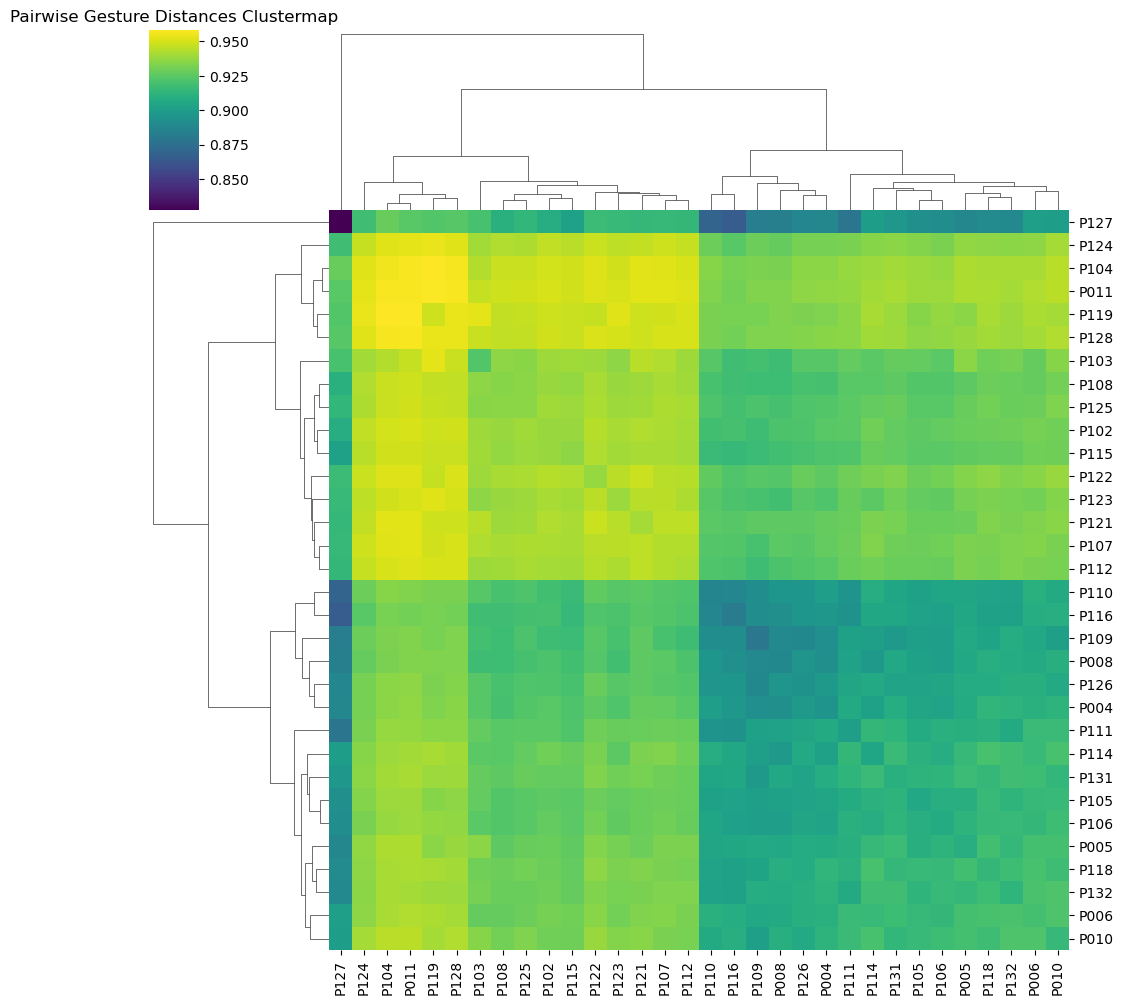

Clustermap completed in 1.6865649223327637s


In [41]:
clsmap_obj1, distance_matrix1 = clustermap_users(users_submatrices, participant_labels, dist_metric='cosine', dist_norm='fro', dist_method='mean')


Distance matrix completed in 271.3481216430664s


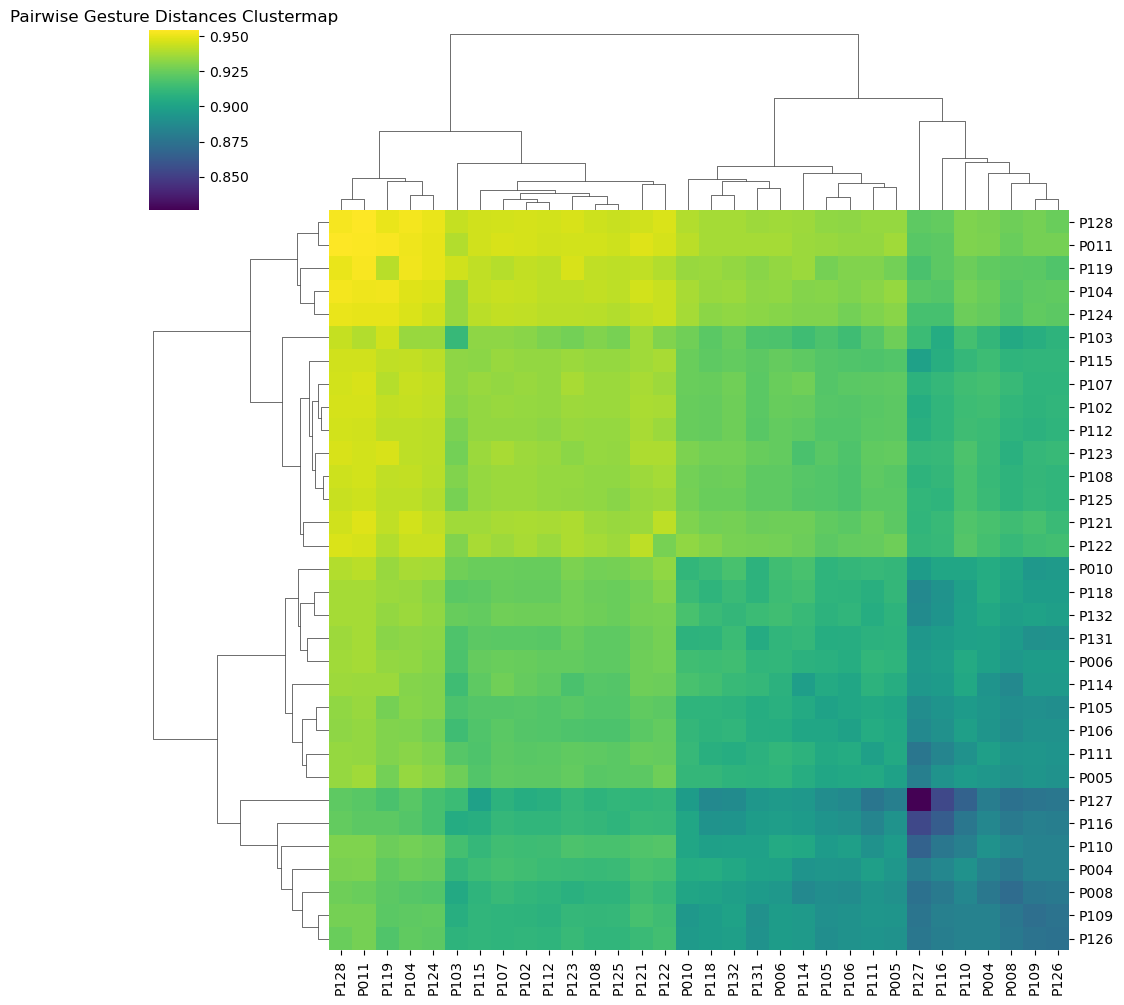

Clustermap completed in 0.9361770153045654s


In [42]:
clsmap_obj2, distance_matrix2 = clustermap_users(users_submatrices, participant_labels, dist_metric='correlation', dist_norm='fro', dist_method='mean')


Distance matrix completed in 0.048757314682006836s


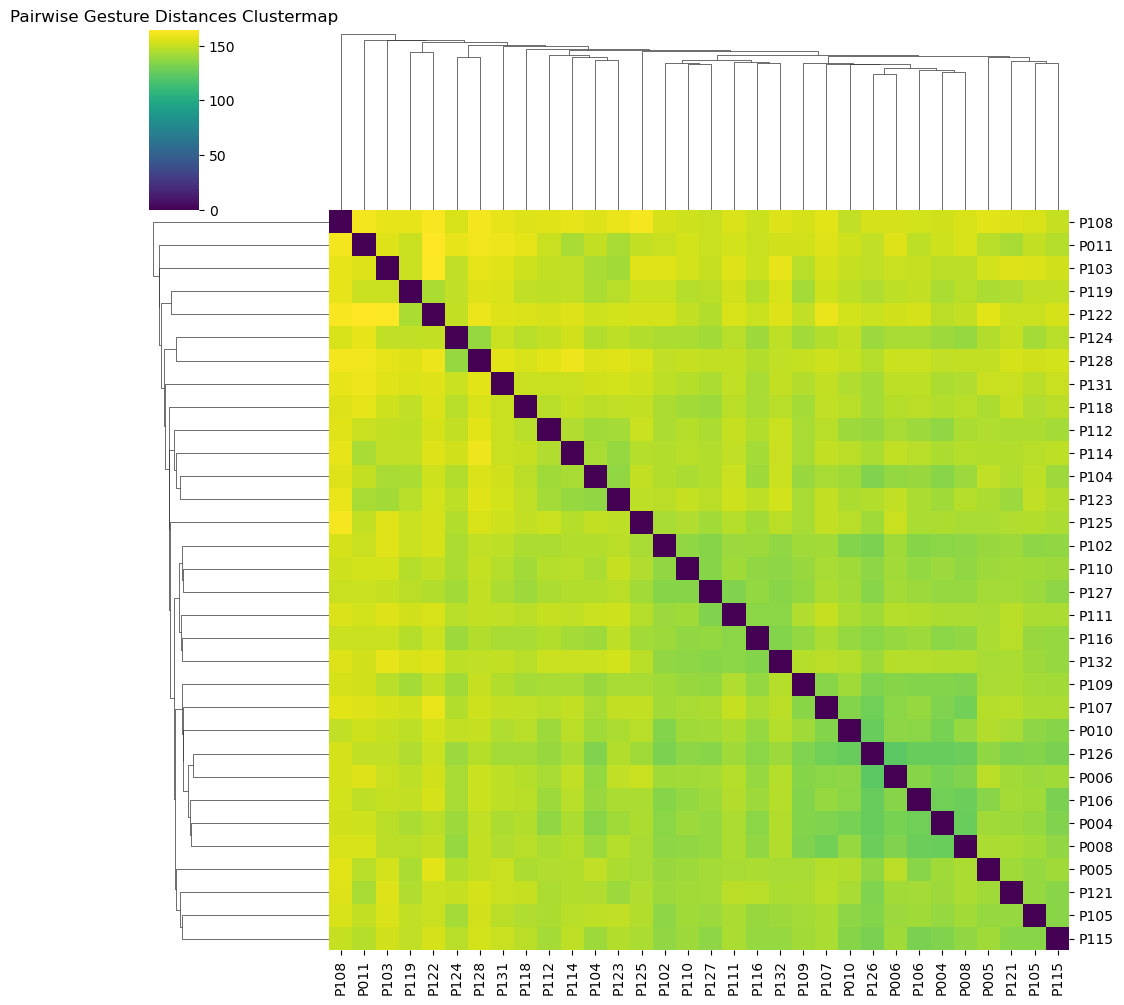

Clustermap completed in 1.0012214183807373s


In [43]:
clsmap_obj3, distance_matrix3 = clustermap_users(users_submatrices, participant_labels, dist_metric=None, dist_norm='fro', dist_method='norm')
